Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
total 462164
-rw-r--r-- 1 root root  177907989 Jun  1 11:47 data.tgz
drwx------ 4 root root       4096 Jun  1 11:47 gdrive
drwxr-xr-x 1 root root       4096 May 27 16:27 sample_data
-rw-r--r-- 1  501 staff 147000128 Mar 15  2019 x_test.npy
-rw-r--r-- 1  501 staff 148312628 Mar 15  2019 x_train.npy
-rw-r--r-- 1  501 staff      6400 Mar 15  2019 y_test.npy
-rw-r--r-- 1  501 staff      6456 Mar 15  2019 y_train.npy
X_TRAIN: (791, 250, 250, 3)
Y_TRAIN: (791,)
X_T

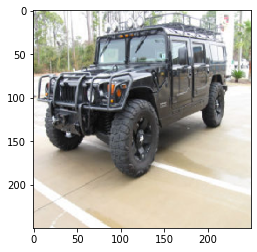

(791, 20)
(784, 20)
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
__________________________________________

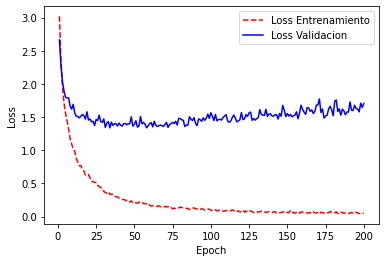

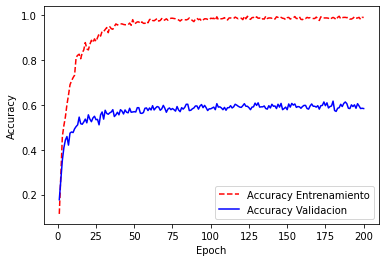

In [1]:
# -*- coding: utf-8 -*-


from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
#from google.colab import drive
#drive.mount("/content/gdrive")
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16



batch_size = 32
num_classes = 20
epochs = 200



#### LOAD AND TRANSFORM

## Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')
#####

!ls -l

# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print("X_TRAIN: " + str(x_train.shape))
print("Y_TRAIN: " + str(y_train.shape))

print("X_TEST: " + str(x_test.shape))
print("Y_TEST: " + str(y_test.shape))

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test.shape)
###########################################################


############################################################

datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True
  )
datagen.fit(x_train)

## OPTIM
opt = Adam(lr=0.01)


# DEFINE A LEARNING RATE SCHEDULER
"""
def scheduler(epoch):
    if epoch < 500:
        return .01
    elif epoch < 1000:
        return 0.001
    else:
        return 0.0001

set_lr = LRS(scheduler)

"""
#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,7*7)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)								              # Apply l2 normalization
  return z_l2



model1 = VGG16(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
model1.summary()

for layer in model1.layers:
  layer.trainable = False

conv=model1.get_layer('block5_pool') # block5_pool

"""
conv = Conv2D(512,
                  kernel_size=(3,3),
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal')(conv.output)

conv = Conv2D(512,
                  kernel_size=(3,3),
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal')(conv)
"""
d1=Dropout(0.5)(conv.output)
d2=Dropout(0.5)(conv.output)

x = Lambda(outer_product, name='outer_product')([d1,d2])
x = Dropout(0.5)(x)
#predictions=Dense(64, activation='softmax', name='predictions')(x)
out=Dense(num_classes, activation='softmax', name='out')(x)

model = Model(inputs=model1.input, outputs=out)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
  
model.summary()



## TRAINING with DA and LRA

mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Data/BilinearCarsVGG16FreezeV5.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')


history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[mcp_save],
                            verbose=1)

"""

history=model.fit(x_train, y_train, batch_size=batch_size,
                            steps_per_epoch=len(x_train) / batch_size, epochs=1000,
                            validation_data=(x_test, y_test),
                            callbacks=[mcp_save],
                            verbose=1)
"""

## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

import matplotlib.pyplot as plt

#NUMERO DE EPOCHS
num_epochs = range(1, len(history.history['loss']) + 1)

#GRAFICO DEL ENTRENAMIENTO
plt.plot(num_epochs, history.history['loss'], 'r--')
plt.plot(num_epochs, history.history['val_loss'], 'b-')
plt.legend(['Loss Entrenamiento', 'Loss Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#GRAFICO DEL ENTRENAMIENTO ACCURACY
plt.plot(num_epochs, history.history['accuracy'], 'r--')
plt.plot(num_epochs, history.history['val_accuracy'], 'b-')
plt.legend(['Accuracy Entrenamiento', 'Accuracy Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Epoch 1/200
25/24 [==============================] - 22s 867ms/step - loss: 3.4232 - accuracy: 0.1252 - val_loss: 2.9408 - val_accuracy: 0.0969
Epoch 2/200
25/24 [==============================] - 22s 887ms/step - loss: 2.9683 - accuracy: 0.0923 - val_loss: 2.9035 - val_accuracy: 0.1059
Epoch 3/200
25/24 [==============================] - 20s 780ms/step - loss: 2.9965 - accuracy: 0.0910 - val_loss: 3.0579 - val_accuracy: 0.0702
Epoch 4/200
25/24 [==============================] - 19s 771ms/step - loss: 3.0290 - accuracy: 0.0518 - val_loss: 2.9714 - val_accuracy: 0.0523
Epoch 5/200
25/24 [==============================] - 19s 771ms/step - loss: 3.0139 - accuracy: 0.0480 - val_loss: 2.9707 - val_accuracy: 0.0446
Epoch 6/200
25/24 [==============================] - 19s 770ms/step - loss: 2.9633 - accuracy: 0.0683 - val_loss: 2.9459 - val_accuracy: 0.0459
Epoch 7/200
25/24 [==============================] - 19s 773ms/step - loss: 2.9459 - accuracy: 0.0746 - val_loss: 2.9294 - val_accuracy:

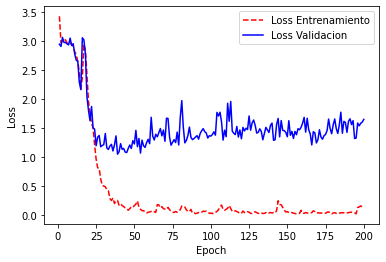

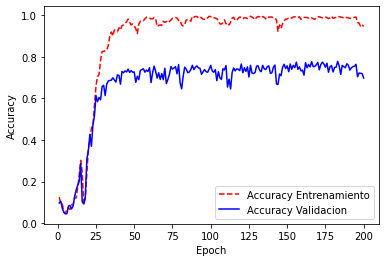

In [0]:

model = load_model("/content/gdrive/My Drive/Data/BilinearCarsVGG16FreezeV5.hdf5")

for layer in model.layers:
  layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('/content/gdrive/My Drive/Data/BilinearCarsVGG16NoFreezeV5.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

epochs = 200

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 500:
        return .00001
    elif epoch < 800:
        return 0.0001
    else:
        return 0.0001

set_lr = LRS(scheduler)

history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[mcp_save],
                            verbose=1)
"""
history=model.fit(x_train, y_train,batch_size=batch_size,
                            steps_per_epoch=len(x_train) / batch_size, epochs=500,
                            validation_data=(x_test, y_test),
                            callbacks=[mcp_save],
                            verbose=1)
"""


## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

import matplotlib.pyplot as plt

#NUMERO DE EPOCHS
num_epochs = range(1, len(history.history['loss']) + 1)

#GRAFICO DEL ENTRENAMIENTO
plt.plot(num_epochs, history.history['loss'], 'r--')
plt.plot(num_epochs, history.history['val_loss'], 'b-')
plt.legend(['Loss Entrenamiento', 'Loss Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#GRAFICO DEL ENTRENAMIENTO ACCURACY
plt.plot(num_epochs, history.history['accuracy'], 'r--')
plt.plot(num_epochs, history.history['val_accuracy'], 'b-')
plt.legend(['Accuracy Entrenamiento', 'Accuracy Validacion'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()